<a href="https://colab.research.google.com/github/mirandaelisa/NBA_match_outcome_prediction/blob/main/predicting_NBA_match_outcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting NBA Match Outcomes Using Halftime Data

This project analyzes NBA shot and scoring data to predict whether the home team will win a game based on halftime performance.
The goal is to explore the relationship between first-half scoring and game outcomes using data-driven methods.

# Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Reading, cleaning, and preparing the dataset

In [36]:
# Reading the dataframe

shotlog = pd.read_csv('https://raw.githubusercontent.com/mirandaelisa/NBA_match_outcome_prediction/refs/heads/main/data/NBA_Shotlog_16_17.csv')
shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,1:09,10/27/2016,Kent Bazemore,NaN,1,MISSED
1,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,1:11,10/27/2016,Dwight Howard,2.0,1,SCORED
2,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,1:41,10/27/2016,Kyle Korver,30.0,1,SCORED
3,SCORED,PG,Yes,102.0,SCORED,ATL,Pullup Jump Shot,2,WAS,385.0,2:16,10/27/2016,Dennis Schroder,35.0,1,SCORED
4,SCORED,PF,Yes,128.0,MISSED,ATL,Turnaround Jump Shot,2,WAS,265.0,2:40,10/27/2016,Paul Millsap,24.0,1,MISSED


In [3]:
shotlog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210072 entries, 0 to 210071
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   team_previous_shot      207612 non-null  object 
 1   player_position         210072 non-null  object 
 2   home_game               210072 non-null  object 
 3   location_x              209675 non-null  float64
 4   opponent_previous_shot  208462 non-null  object 
 5   home_team               210072 non-null  object 
 6   shot_type               210072 non-null  object 
 7   points                  210072 non-null  int64  
 8   away_team               210072 non-null  object 
 9   location_y              209675 non-null  float64
 10  time                    210072 non-null  object 
 11  date                    210072 non-null  object 
 12  shoot_player            210072 non-null  object 
 13  time_from_last_shot     200072 non-null  float64
 14  quarter             

In [4]:
# Selecting only scored shots

shotlog_scored = shotlog[shotlog['current_shot_outcome'] == 'SCORED'].reset_index(drop=True)
shotlog_scored.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,time,date,shoot_player,time_from_last_shot,quarter,current_shot_outcome
0,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,1:11,10/27/2016,Dwight Howard,2.0,1,SCORED
1,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,1:41,10/27/2016,Kyle Korver,30.0,1,SCORED
2,SCORED,PG,Yes,102.0,SCORED,ATL,Pullup Jump Shot,2,WAS,385.0,2:16,10/27/2016,Dennis Schroder,35.0,1,SCORED
3,MISSED,PF,Yes,167.0,MISSED,ATL,Pullup Jump Shot,2,WAS,306.0,4:51,10/27/2016,Paul Millsap,47.0,1,SCORED
4,BLOCKED,PG,Yes,54.0,MISSED,ATL,Jump Shot,3,WAS,473.0,5:34,10/27/2016,Dennis Schroder,6.0,1,SCORED


In [5]:
# Grouping scores per quarter

quarter_scores = shotlog_scored.groupby(['date', 'home_team', 'home_game', 'away_team', 'quarter'])['points'].sum().reset_index()
quarter_scores.head(10)

,date,home_team,home_game,away_team,quarter,points
0,1/1/2017,ATL,No,SAS,1,25
1,1/1/2017,ATL,No,SAS,2,16
2,1/1/2017,ATL,No,SAS,3,20
3,1/1/2017,ATL,No,SAS,4,23
4,1/1/2017,ATL,No,SAS,5,9
5,1/1/2017,ATL,Yes,SAS,1,22
6,1/1/2017,ATL,Yes,SAS,2,17
7,1/1/2017,ATL,Yes,SAS,3,20
8,1/1/2017,ATL,Yes,SAS,4,27
9,1/1/2017,ATL,Yes,SAS,5,12


In [6]:
# Separating home and away scores

home_scores = quarter_scores[quarter_scores['home_game'] == 'Yes'].copy()
away_scores = quarter_scores[quarter_scores['home_game'] == 'No'].copy()

In [7]:
home_scores = home_scores.rename(columns={'points': 'home_points'})
away_scores = away_scores.rename(columns={'points': 'away_points'})

In [8]:
home_scores.head()

,date,home_team,home_game,away_team,quarter,home_points
5,1/1/2017,ATL,Yes,SAS,1,22
6,1/1/2017,ATL,Yes,SAS,2,17
7,1/1/2017,ATL,Yes,SAS,3,20
8,1/1/2017,ATL,Yes,SAS,4,27
9,1/1/2017,ATL,Yes,SAS,5,12


In [9]:
away_scores.head()

,date,home_team,home_game,away_team,quarter,away_points
0,1/1/2017,ATL,No,SAS,1,25
1,1/1/2017,ATL,No,SAS,2,16
2,1/1/2017,ATL,No,SAS,3,20
3,1/1/2017,ATL,No,SAS,4,23
4,1/1/2017,ATL,No,SAS,5,9


In [10]:
merged_scores = pd.merge(home_scores, away_scores, on=['date', 'quarter', 'home_team', 'away_team'], how='inner')
merged_scores

,date,home_team,home_game_x,away_team,quarter,home_points,home_game_y,away_points
0,1/1/2017,ATL,Yes,SAS,1,22,No,25
1,1/1/2017,ATL,Yes,SAS,2,17,No,16
2,1/1/2017,ATL,Yes,SAS,3,20,No,20
3,1/1/2017,ATL,Yes,SAS,4,27,No,23
4,1/1/2017,ATL,Yes,SAS,5,12,No,9
...,...,...,...,...,...,...,...,...
4994,4/9/2017,PHX,Yes,DAL,4,18,No,21
4995,4/9/2017,SAC,Yes,HOU,1,22,No,35
4996,4/9/2017,SAC,Yes,HOU,2,29,No,27
4997,4/9/2017,SAC,Yes,HOU,3,23,No,22


In [11]:
# Getting halftime scores

halftime = merged_scores[merged_scores['quarter'].isin([1, 2])]
halftime.head()

,date,home_team,home_game_x,away_team,quarter,home_points,home_game_y,away_points
0,1/1/2017,ATL,Yes,SAS,1,22,No,25
1,1/1/2017,ATL,Yes,SAS,2,17,No,16
5,1/1/2017,IND,Yes,ORL,1,20,No,16
6,1/1/2017,IND,Yes,ORL,2,32,No,29
9,1/1/2017,LAL,Yes,TOR,1,22,No,22


In [12]:
halftime_totals = halftime.groupby(['date', 'home_team', 'away_team'])[['home_points', 'away_points']].sum().reset_index()
halftime_totals.head()

,date,home_team,away_team,home_points,away_points
0,1/1/2017,ATL,SAS,39,41
1,1/1/2017,IND,ORL,52,45
2,1/1/2017,LAL,TOR,40,41
3,1/1/2017,MIA,DET,58,48
4,1/1/2017,MIN,POR,43,30


In [13]:
halftime_totals['ht_lead_home'] = halftime_totals['home_points'] - halftime_totals['away_points']
halftime_totals.head()

,date,home_team,away_team,home_points,away_points,ht_lead_home
0,1/1/2017,ATL,SAS,39,41,-2
1,1/1/2017,IND,ORL,52,45,7
2,1/1/2017,LAL,TOR,40,41,-1
3,1/1/2017,MIA,DET,58,48,10
4,1/1/2017,MIN,POR,43,30,13


In [14]:
# Getting final scores and match winner

final_scores = merged_scores.groupby(['date', 'home_team', 'away_team'])[['home_points', 'away_points']].sum().reset_index()
final_scores.head()

,date,home_team,away_team,home_points,away_points
0,1/1/2017,ATL,SAS,98,93
1,1/1/2017,IND,ORL,95,94
2,1/1/2017,LAL,TOR,89,94
3,1/1/2017,MIA,DET,84,93
4,1/1/2017,MIN,POR,77,78


In [15]:
final_scores['home_won'] = (final_scores['home_points'] > final_scores['away_points']).astype(int)
final_scores

,date,home_team,away_team,home_points,away_points,home_won
0,1/1/2017,ATL,SAS,98,93,1
1,1/1/2017,IND,ORL,95,94,1
2,1/1/2017,LAL,TOR,89,94,0
3,1/1/2017,MIA,DET,84,93,0
4,1/1/2017,MIN,POR,77,78,0
...,...,...,...,...,...,...
1225,4/9/2017,LAL,MIN,94,83,1
1226,4/9/2017,MEM,DET,81,92,0
1227,4/9/2017,NYK,TOR,83,90,0
1228,4/9/2017,PHX,DAL,96,98,0


In [16]:
df = pd.merge(halftime_totals, final_scores[['date', 'home_team', 'away_team', 'home_won']], on=['date', 'home_team', 'away_team'])
df

,date,home_team,away_team,home_points,away_points,ht_lead_home,home_won
0,1/1/2017,ATL,SAS,39,41,-2,1
1,1/1/2017,IND,ORL,52,45,7,1
2,1/1/2017,LAL,TOR,40,41,-1,0
3,1/1/2017,MIA,DET,58,48,10,0
4,1/1/2017,MIN,POR,43,30,13,0
...,...,...,...,...,...,...,...
1225,4/9/2017,LAL,MIN,47,35,12,1
1226,4/9/2017,MEM,DET,52,41,11,0
1227,4/9/2017,NYK,TOR,45,43,2,0
1228,4/9/2017,PHX,DAL,53,58,-5,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1230 non-null   object
 1   home_team     1230 non-null   object
 2   away_team     1230 non-null   object
 3   home_points   1230 non-null   int64 
 4   away_points   1230 non-null   int64 
 5   ht_lead_home  1230 non-null   int64 
 6   home_won      1230 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 67.4+ KB


In [18]:
df['date'] = pd.to_datetime(df['date'])
df

,date,home_team,away_team,home_points,away_points,ht_lead_home,home_won
0,2017-01-01,ATL,SAS,39,41,-2,1
1,2017-01-01,IND,ORL,52,45,7,1
2,2017-01-01,LAL,TOR,40,41,-1,0
3,2017-01-01,MIA,DET,58,48,10,0
4,2017-01-01,MIN,POR,43,30,13,0
...,...,...,...,...,...,...,...
1225,2017-04-09,LAL,MIN,47,35,12,1
1226,2017-04-09,MEM,DET,52,41,11,0
1227,2017-04-09,NYK,TOR,45,43,2,0
1228,2017-04-09,PHX,DAL,53,58,-5,0


In [19]:
df['date'].describe()

,date
count,1230
mean,2017-01-17 07:02:38.048780544
min,2016-10-25 00:00:00
25%,2016-12-05 00:00:00
50%,2017-01-16 00:00:00
75%,2017-03-04 00:00:00
max,2017-04-12 00:00:00


# Creating the model

In [20]:
features = ['ht_lead_home']

x = df[features]
y = df['home_won']

SEED = 342

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y)

print(f'Training will be done with: {len(X_train)} observations')
print(f'Testing will be done with: {len(X_test)} observations')

Training will be done with: 984 observations
Testing will be done with: 246 observations


## Logistic Regression model

In [21]:
# Accuracy

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_preds) * 100
print(f'Logistic Regression Accuracy: {log_acc:.2f}%')

Logistic Regression Accuracy: 73.98%


In [22]:
# Confusion matrix

log_cm = confusion_matrix(y_test, log_preds)
log_cm_df = pd.DataFrame(log_cm,
                     index=['Actual Loss', 'Actual Win'],
                     columns=['Predicted Loss', 'Predicted Win'])

print("Logistic Regression Confusion Matrix:")
print(log_cm_df)

Logistic Regression Confusion Matrix:
             Predicted Loss  Predicted Win
Actual Loss              79             33
Actual Win               31            103


In [23]:
print(f'True positive: {log_cm[1][1]}')
print(f'False positive: {log_cm[0][1]}')
print(f'True negative: {log_cm[0][0]}')
print(f'False negative: {log_cm[0][1]}')

True positive: 103
False positive: 33
True negative: 79
False negative: 33


In [24]:
# ROC AUC Score

log_probs = log_model.predict_proba(X_test)[:, 1]
log_roc_auc = roc_auc_score(y_test, log_probs)
print(f"Logistic Regression ROC AUC Score: {log_roc_auc:.2f}")


# probs = model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, probs)
# print(f"ROC AUC Score: {roc_auc:.2f}")

Logistic Regression ROC AUC Score: 0.83


In [25]:
# F1 Score

log_f1_score = f1_score(y_test, log_preds)
print(f"Logistic Regression F1 Score: {log_f1_score:.2f}")

Logistic Regression F1 Score: 0.76


## Random Forest model

In [26]:
# Accuracy

rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds) * 100
print(f'Random Forest Accuracy: {rf_acc:.2f}%')

Random Forest Accuracy: 73.58%


In [27]:
# Confusion Matrix

rf_cm = confusion_matrix(y_test, rf_preds)
rf_cm_df = pd.DataFrame(rf_cm,
                     index=['Actual Loss', 'Actual Win'],
                     columns=['Predicted Loss', 'Predicted Win'])

print("Random Forest Confusion Matrix:")
print(rf_cm_df)

Random Forest Confusion Matrix:
             Predicted Loss  Predicted Win
Actual Loss              76             36
Actual Win               29            105


In [28]:
print(f'True positive: {rf_cm[1][1]}')
print(f'False positive: {rf_cm[0][1]}')
print(f'True negative: {rf_cm[0][0]}')
print(f'False negative: {rf_cm[0][1]}')

True positive: 105
False positive: 36
True negative: 76
False negative: 36


In [29]:
# ROC AUC Score

rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_probs)
print(f"Random Forest ROC AUC Score: {rf_roc_auc:.2f}")

Random Forest ROC AUC Score: 0.82


In [30]:
# F1 Score

rf_f1_score = f1_score(y_test, rf_preds)
print(f"Random Forest F1 Score: {rf_f1_score:.2f}")

Random Forest F1 Score: 0.76


## Comparing the models

In [31]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [log_acc, rf_acc],
    'AUC': [log_roc_auc, rf_roc_auc],
    'F1 Score': [log_f1_score, rf_f1_score]
})

print(comparison)

                 Model   Accuracy       AUC  F1 Score
0  Logistic Regression  73.983740  0.825926  0.762963
1        Random Forest  73.577236  0.823761  0.763636


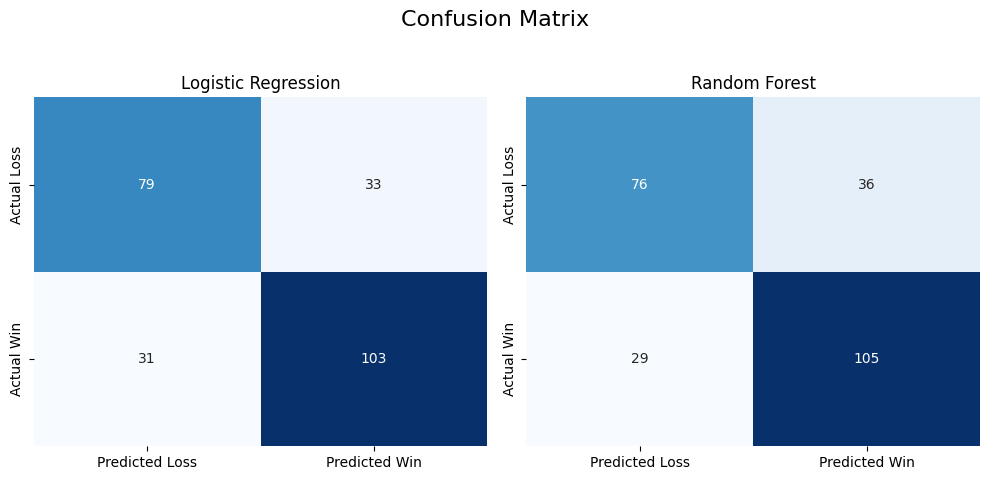

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(log_cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title("Logistic Regression")

sns.heatmap(rf_cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Random Forest")
fig.suptitle("Confusion Matrix", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

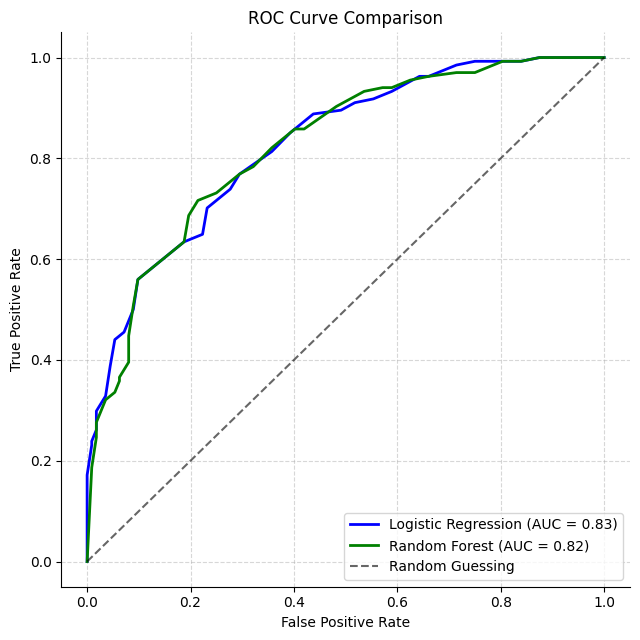

In [33]:
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6.5, 6.5))

plt.plot(log_fpr, log_tpr, label=f"Logistic Regression (AUC = {log_roc_auc:.2f})", linewidth=2, color='blue')
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.2f})", linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing", alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Conclusion

Both models performed similarly, achieving about 74% accuracy. Logistic Regression slightly outperformed Random Forest in AUC, suggesting that halftime lead alone is a strong predictor of the final game outcome.

Future improvements could include incorporating momentum-based features (e.g., scoring runs, late-quarter trends), team statistics, or advanced ensemble methods to capture more game dynamics.